In [16]:
import numpy as np
import pandas as pd
import time as time
import operator
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import display, Image, clear_output
from scipy.spatial.distance import pdist, squareform
from collections import defaultdict

In [17]:
def discrete_kernel(center, minsize):
    dist = np.empty((2*minsize+1,2*minsize+1))
    decay = np.logspace(0,1,minsize+1 )
    
    for xstep in range(-minsize,minsize+1):
        for ystep in range(-minsize,minsize+1):
            dist[1+xstep][1+ystep] = 1 * paint[center[0]+xstep][center[1]+ystep]
            
    return (dist.sum()+0.0)/np.array(dist.shape).prod()

In [18]:
def paint_square(center, minsize):
    for xstep in range(-minsize,minsize+1):
        for ystep in range(-minsize,minsize+1):
            paint[center[0]+xstep][center[1]+ystep] = 0.0

In [19]:
def check_line(line):
    row = line[1]
    col = line[2]
    vline = 0
    hline = 0 
    if paint[row][col]:
        for bit in paint[row, col:]:
            if bit:
                hline += 1
            else:
                break
        for bit in paint[row:, col]:
            if bit:
                vline += 1
            else:
                break
    if hline < lthresh:
        hline = 0;
    if vline < lthresh:
        vline = 0;
    newline = (line[0], line[1], line[2], hline, vline)
    return newline

In [20]:
def paint_line(line):
    cmds = 0;
    if line[3] > line[4]:
        paint[line[1],range(line[2], line[3] + line[2])] = 0.0
        cmds += 1
    elif line[3] == line[4]:
        paint[line[1] , range(line[2], line[3] + line[2])] = 0.0
        paint[range(line[1], line[1] + line[4]) , line[2]] = 0.0
        if line[3] == 1:
            cmds += 1
        else:
            cmds += 2
    else:
        paint[range(line[1], line[1] + line[4]) , line[2]] = 0.0
        cmds += 1
    return cmds

In [21]:
def write_squares(n, commands, path):
    with open(path, 'w') as fh:
        fh.write('{}\n'.format(n))
        for command in commands:
            if command[0] > 0:
                fh.write('PAINT_SQUARE '+str(command[2])+ ' ' + str(command[1])+ ' ' + str(command[0]) + '\n')
            else:
                # fh.write('ERASE_CELL {} {}\n'.format(*command[1:3]))
                print 'hello'


In [22]:
def write_lines(commands, path):
    with open(path, 'a') as fh:
        for command in commands:
            fh.write('PAINT_LINE '+str(command[2])+ ' ' + str(command[1])+ ' ' + str(command[0]) + '\n')

In [23]:
filepath = '/Users/alfredogarbuno/github-repos/hashcode-2015/data/logo.in'
f = open(filepath, "r+")
dimstr = f.readline().split()
paint = np.empty([int(dimstr[0]), int(dimstr[1])])

for i in range(int(dimstr[0])):
    paint[i] = np.array(list(f.readline().split()[0].replace(".", "0").replace("#", "1")), np.int32)
    
f.close()

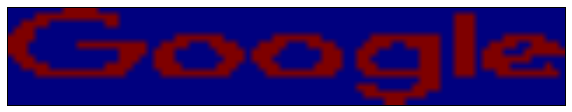

In [24]:
plt.figure(figsize=(10,10))
plt.imshow(paint)
fig = plt.gca()
fig.axes.get_xaxis().set_visible(False)
fig.axes.get_yaxis().set_visible(False)

In [25]:
dim = np.array(dimstr, np.int32)
density = paint.sum() / dim.prod()
minsize = int(dim.min() * density)
print minsize
# Parameters
minsize = 1
threshold = 1
linecmds = []
print minsize
indices = np.arange(1,dim.prod()+1).reshape(dim)

3
1


In [26]:
lines = []
for row in range(indices.shape[0]):
    for col in range(indices.shape[1]):
        if paint[row][col]:
            vline = 0
            hline = 0 
            for bit in paint[row, col:]:
                if bit:
                    hline += 1
                else:
                    break
            for bit in paint[row:, col]:
                if bit:
                    vline += 1
                else:
                    break
            lines.append( (indices[row,col], row, col, hline, vline) )
                    
lines = sorted(lines, key=lambda element: (-max(element[3], element[4]), element[0]))

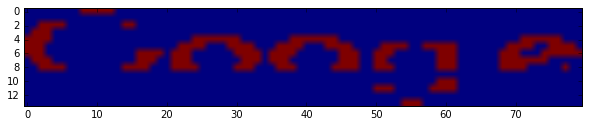

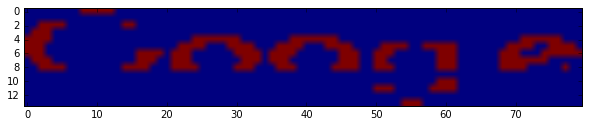

In [27]:
plt.figure(figsize=(10,10))
lthresh = 9;
for line in lines:
    nwline = check_line(line)
    if max(nwline[3],nwline[4]) > 0:
        cmds = paint_line(line)
        linecmds.append(cmds)
        plt.imshow(paint)
        clear_output(wait=True)
        display(plt.gcf())
        time.sleep(0.001)

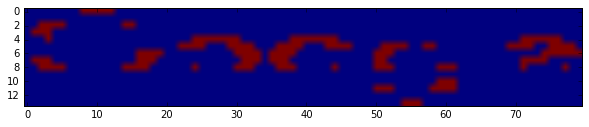

In [28]:
# This paints with squares

paints = defaultdict(list)
zeros = 0;
plt.figure(figsize=(10,10))

while minsize > 0:
    # Create centers
    row, col = np.indices((dim[0]-2*minsize, dim[1]-2*minsize))
    centers = indices[row+minsize, col+minsize]
    # Create candidate list
    cands = []
    cands = [ (ycoord, discrete_kernel([row+minsize, ycoord%dim[1]-1], minsize)) for row in range(centers.shape[0]) 
            for ycoord in centers[row]]
    # Filter candidates
    cands = [(key, value) for (key,value) in cands if value >= threshold]
    cands = sorted(cands, key=lambda element: (-element[1], element[0]))
    # Begin drawing with squares
    for cand in cands:
        center = ( cand[0] // dim[1], cand[0] % dim[1] - 1)
        if cand[0] == cands[0][0]:
            zeros += (1-cand[1]) * (2*minsize + 1)**2
            paint_square(center, minsize)
            paints[minsize].append(center)
            plt.imshow(paint)
            clear_output(wait=True)
            display(plt.gcf())
            time.sleep(0.001)
        else:
            if discrete_kernel(center, minsize) >= threshold:
                zeros += (1-cand[1]) * (2*minsize + 1)**2
                paint_square(center, minsize)
                paints[minsize].append(center)
                plt.imshow(paint)
                clear_output(wait=True)
                display(plt.gcf())
                time.sleep(0.001)
                
    minsize += -1

clear_output(wait=True)

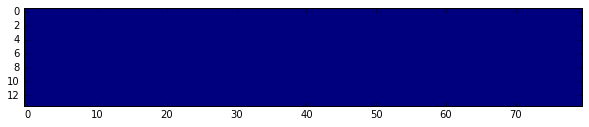

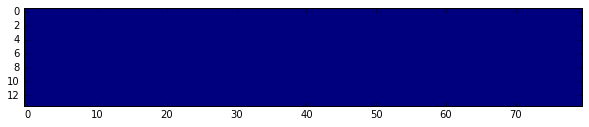

In [29]:
plt.figure(figsize=(10,10))
lthresh = 0;
for line in lines:
    nwline = check_line(line)
    if max(nwline[3],nwline[4]) > 0:
        cmds = paint_line(line)
        linecmds.append(cmds)
        plt.imshow(paint)
        clear_output(wait=True)
        display(plt.gcf())
        time.sleep(0.001)

In [30]:
# Total pixels
print "Free pixels: ", paint.sum()
# Total erases
print "Erase commands: ", zeros
# Total squares
print "Square commands: ", sum([ v for (k,v) in [ (key,len(paints[key])) for key in paints.keys() ]])
# Total of line commands
print "Line commands: ", len(linecmds)

Free pixels:  0.0
Erase commands:  0.0
Square commands:  5
Line commands:  61
